# Part 1: Regular expression warmup

In these questions, you are expected to use functionality from the Python regular expression module: re.

## Used libraries

In [113]:
import re
import pandas as pd
from cleantext import clean
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import random

## a)

Danish CPR numbers consist of a six-digit date (DDMMYY), followed by a 4 digit identifier (IIII). Using the re module, the task is to write and apply a regular expression that matches any CPR number, either in the DDMMYYIIII format, or in the DDMMYY-IIII format. The regular expression should contain four groups, such that the DD, MM, YY, and IIII parts can be extracted after matching.

In [114]:
def extract_cpr_parts(cpr_number):
    return re.findall(r"""
                         (\d{2}) # DD-part
                         (\d{2}) # MM-part
                         (\d{2}) # YY-part
                         -?
                         (\d{4}) # IIII-part
                         """,
                      cpr_number, re.X) # re.X for writing comments to pattern and makes it looks nicer!

### Test:

In [115]:
#print(extract_cpr_parts("0302941048"))

## b)

The 4-digit identifier together with the last two digits of the date (i.e. the year), encodes in which century a person is born, using the following system

|     IIII         |     YY       |     Born in century    |
|------------------|--------------|------------------------|
|     0001-3999    |     00-99    |     1900               |
|     4000-4999    |     00-36    |     2000               |
|     4000-4999    |     37-99    |     1900               |
|     5000-8999    |     00-57    |     2000               |
|     5000-8999    |     58-99    |     1800               |
|     9000-9999    |     00-36    |     2000               |
|     9000-9999    |     37-99    |     1900               |

Note that in this table, both numbers in a range are included (e.g. 00-99 includes both 00 and 99).

Write a function that returns the relevant century based on the information in the table above, and returns either 1800, 1900 or 2000 (as an integer).

In [116]:
def find_century(identifier, year):
    conditions = {
        #IIII              #YEAR
        (range(1   ,3999), range(0 ,99)): 1900,
        (range(4000,4999), range(0 ,36)): 2000,
        (range(4000,4999), range(37,99)): 1900,
        (range(5000,8999), range(0 ,57)): 2000,
        (range(5000,8999), range(58,99)): 1800,
        (range(9000,9999), range(0 ,36)): 2000,
        (range(9000,9999), range(37,99)): 1900,
    }
    
    # Loopt through each element in dictionary and check if they match the given identifier
    for c, century in conditions.items():
        if identifier in c[0] and year in c[1]: # c[0] specified IIII, c[1] specified year
            return century
    return None

# Part 2: Processing the FakeNewsCorpus data set

This exercise is focused on getting the FakeNewsCorpus dataset in a reasonable shape, and doing some initial exploration of the data. This should be directly useful for your final project. We will be working on a sample of the FakeNews corpus: <a href="https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv" target="_blank" class="external" rel="noreferrer noopener">

## 1) Read the CSV file

In [117]:
# Load/read the csv file into a panda DataFrame
df = pd.read_csv('news_sample.csv')

## 2) Manually inspect the data to get an idea of potential problems of the data structure and representation that need to be fixed.

Some of the "type" are missing, meaning we cannot determine some of the types of news.

## 3) Clean the data

### Clean data manually:

First, we'll try to do this manually, by writing our own clean_text() function that uses regular expressions. The function should take raw text as input and return a version of the text with the following modifications:
<ul>
<li>all words must be lowercased</li>
<li>it should not contain multiple white spaces, tabs, or new lines</li>
<li>numbers, dates, emails, and URLs should be replaced by "&lt;NUM&gt;", "&lt;DATE&gt;", "&lt;EMAIL&gt;" AND "&lt;URL&gt;", respectively. Note that replacing dates with &lt;DATE&gt; is particularly tricky as dates can be expressed in many forms. You may just choose one or a few common date formats present in the data set and only replace those. (Be careful about tokenizing &lt;&gt; symbols because these are punctuation in most Tokenizers).</li>
</ul>

In [118]:
def clean_text_man(df):
    # Dictionary of patterns and their appreciate replacements
    dict_patterns = {
        r'(\s{2,})': ' ',
        r'(\t+)': '(\t)',
        r'(\n+)': '(\n)',
        r'(\d{1,2}[-/\\]\d{1,2}[-/\\]\d{2,4}|\d{2,4}[-/\\]\d{1,2}[-/\\]\d{1,2})|\w{3}\s\d{1,2}[\s,]\d{4}|\d{1,2}\s\w{3}\s\d{4}|(?:jan(?:uary)?|feb(?:ruary)|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)[\s,]\d{2}[\s,]\d{2,4}|\d{2}[\s,](?:jan(?:uary)?|feb(?:ruary)|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)[\s,]\d{2,4}': ' <DATE> ',
        r'([\w.\-]+@(?:[\w-]+\.)+[\w-]{2,4})': '<EMAIL>',
        r'(https?:\/\/(?:www\.)?[a-zA-Z0-9-_\+=.:~@#%]+\.[a-zA-Z0-9()]{1,6}\b(?:[a-zA-Z0-9-_.:\\/@#$%&()=+~]*))': '<URL>',
        r'(?<=\s)(-?[0-9]\d*[.,]?\d+)(?=\s)': '<NUM>',
    }

    # Lower case each word element-wise
    df = df.applymap(lambda x: x.lower() if type(x) == str else x)
    
    # Loop through each pattern and apply the pattern to each column and do replacement if needed
    for pattern, replacement in dict_patterns.items():
        df = df.applymap(lambda x: re.sub(pattern, replacement, str(x)))
    
    return df

In [119]:
cleaned_content_man = clean_text_man(df)

### Clean data using library:

Now, let's try to use a library for cleaning the data. The clean-text module (<a class="instructure_file_link inline_disabled external" href="https://pypi.org/project/clean-text/" target="_blank"><span>https://pypi.org/project/clean-text/</span></a>) provides out-of-the-box functionality for much of the cleaning we did in the previous exercise (<span id="pip-command">pip install clean-text</span>). Use it to implement the same cleaning steps as in your own clean_text implementation.

In [120]:
def clean_text_auto(df):
    return df.applymap(lambda x: clean(x,
                                        lower=True,                    # lowercase text
                                        # fully strip line breaks as opposed to only normalizing them
                                        no_line_breaks=True,
                                        no_urls=True,                  # replace all URLs with <url>
                                        no_emails=True,                # replace all email addresses with <email>
                                        no_numbers=True,               # replace all numbers with <num>
                                        replace_with_url="<URL>",
                                        replace_with_email="<EMAIL>",
                                        replace_with_number="<NUM>",
                                        lang="en"
                                        ))

In [121]:
cleaned_content_auto = clean_text_auto(df)

# Part 3: Descriptive frequency analysis of the data

Now, we will do some simple exploration of the data to understand the effect of preprocessing conducted in part 2, the vocabulary, and the frequency distribution of the vocabulary across documents.

## 1) Calculate the number of unique words in the data after preprocessing and compare it to the number of unique words before preprocessing (i.e. in the raw data).

In [122]:
def count_unique_words(df):
    # Create a set since each object must be distinct
    unique_words = set()
    # Loop through each element in dataframe
    for index, row in df.iterrows():
        for value in row:
            if type(value) == str:
                # Split string and remove special characters at start and end of the string
                words = value.split()
                # Loop through each word and remove any trailing and leading characters
                for i in range(len(words)):
                    words[i] = words[i].rstrip(',.()"?:`´”“-–[]').lstrip(',.()"?:`´”“-–[]')
                # Update the set of unique strings
                unique_words.update(words)
    # Return the list of unique words
    return unique_words

In [123]:
# Count unique words before and after processing
unique_words_before = count_unique_words(df)
unique_words_after = count_unique_words(cleaned_content_man)

print('Number of unique words: Before={:d}; After={:d}'.format(
    len(unique_words_before), len(unique_words_after)))

Number of unique words: Before=23230; After=19652


## 2) Calculate how frequently each of these words is used in the dataset. Sort this list, so that the most frequent word appears first, and then use Python's matplotlib library to plot a barplot where the 50 most frequent words appear on the x-axis, and their frequency appears on the y-axis.

### !! Please note the following.
Stopwords are moved in the following using NLTK's stopwords.words() method.
See 10 randomly stopwords from the method below.
In addition, I have also removed some words that I also see as unimportant - useless data that are not captured during pre-processing.
One could argue that even more of these words should be ignored.

In [124]:
print(', '.join(random.sample(stopwords.words("english"), 10)))

aren, her, so, can, shouldn, they, those, having, needn, the


### Plot the 50 most frequent words

In [125]:
def word_frequency(df):
    # Split and remove stopwords (useless data)
    stopWords = stopwords.words("english")
    extraUselessWords = ['nan', '<NUM>:<NUM>:<NUM>', '–', '&', '['']', '—', '01:19:41.756632', '01:19:41.756664', '16:17:44.789555']
    wordsToIgnore = stopWords + extraUselessWords
    
    # Split each cell into a complete list of words and remove any words to ignore
    df.applymap(lambda x: [word for word in x.split() if not word in wordsToIgnore])
    
    # Count the frequency of each word
    frequency = Counter()
    # Update the list of how frequent each words occurs
    df.applymap(lambda x: frequency.update(x))
    
    # Sort the dictionary based on the frequency of each word
    return sorted(frequency.items(), key=lambda x: x[1], reverse=True)


In [126]:
def plot_word_frequency(sorted_frequency):
    # Number of words to list of frequency
    nwords = 50

    # Extract the words and their frequency from the sorted list
    words = [x[0] for x in sorted_frequency[:nwords]]
    frequency = [x[1] for x in sorted_frequency[:nwords]]

    # Plot a barplot using matplotlib
    plt.bar(words, frequency)
    plt.ylabel('Frequency')
    plt.title('Frequency of the 50 most frequent words')
    plt.xticks(rotation=90)
    plt.show()

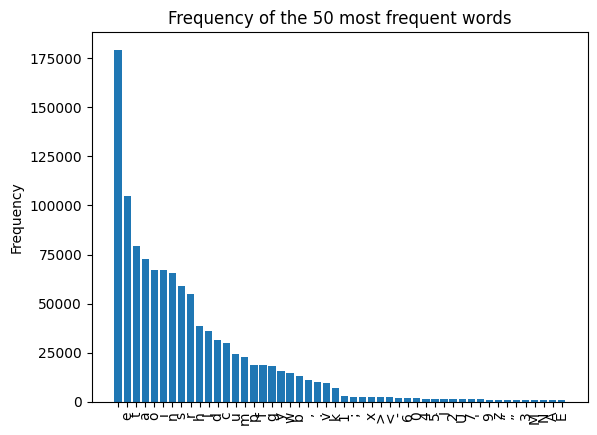

In [127]:
sorted_frequency = word_frequency(cleaned_content_man)
plot_word_frequency(sorted_frequency)